# MCDA modelling of suitable habitats for the re-introduction of estrela edulis  in the German EEZ
This skript in R language runs the suitability analysis to indicate suitable habitats for the European Oyster as highlighted
in this paper. As indicated in section IV(b) this program does not include prior preprocessing of individual input geodata. 
For information in this regard please direct to the author.

## [I] Install and load necessairy packages

In [3]:
requiredPackages <- c("sp", "rgeos", "raster", "rgdal", "ahpsurvey", "reticulate") 
options(warn=-1)

ipak <- function(pkg){
  new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
  if (length(new.pkg))
    install.packages(new.pkg, dependencies = TRUE)
  sapply(pkg, require, character.only = TRUE)
}
ipak(requiredPackages)

is_inst <- function(pkg) {nzchar(system.file(package = pkg))}

sp      rgeos     raster      rgdal  ahpsurvey reticulate 
      TRUE       TRUE       TRUE       TRUE       TRUE       TRUE

In [26]:
# introduce custom geoprocessing function
gClip <- function(shp, bb){
  if(class(bb) == "matrix") b_poly <- as(extent(as.vector(t(bb))), "SpatialPolygons")
  else b_poly <- as(extent(bb), "SpatialPolygons")
  gIntersection(shp, b_poly, byid = T)
}


nonnamax <- function(x) ifelse( !all(is.na(x)), max(x, na.rm=T),NA)
nonnamin <- function(x) ifelse( !all(is.na(x)), min(x, na.rm=T),NA)
nonanabsmax <- function(x)  ifelse( !all(is.na(x[which.max( abs(x) )])), min(x[which.max( abs(x) )], na.rm=T),NA)

## [II] Load expert's questionaires of pairwise factor comparisons

In [12]:
# use custom python scripts to preprocess excel files
if (py_module_available("pandas") == F){py_install("pandas")}
if (py_module_available("xlrd") == F){py_install("xlrd")}  
source_python("xls-in/fct_xlsx2ascii.py")             
source_python("xls-in/read_resort_del_answers.py")   

old_files <- list.files(path="./kaggle/working/", pattern="*.txt", full.names=TRUE, recursive=FALSE)  
for (ifile in seq_along(old_files)){
  unlink(old_files[ifile])
}

In [13]:
files <- list.files(path="xls-in", pattern="*surve", full.names=TRUE, recursive=FALSE)

for (ifile in seq_along(files)){
  print(files[ifile])
  filename_out <- paste("./kaggle/working/",toString(ifile),".txt",sep="")
  tmp <- xlsx2ascii(files[ifile])
  write.table(tmp,file=filename_out,sep="\t",col.names=c("FEAT1","FEAT2","WGT"),row.names = FALSE)
}

[1] "xls-in/survey_for_suitability_analysis_oyster_110520_BC.xlsx"
[1] "xls-in/survey_for_suitability_analysis_oyster_110520_Bp.xlsx"
[1] "xls-in/survey_for_suitability_analysis_oyster_110520_CP.xlsx"
[1] "xls-in/survey_for_suitability_analysis_oyster_110520_ed-TH.xlsx"
[1] "xls-in/survey_for_suitability_analysis_oyster_110520_ed (002)_VM.xlsx"
[1] "xls-in/survey_for_suitability_analysis_oyster_110520_ed_cg.xlsx"


In [14]:
# option to use exclude factors included in the survey - salinity was previously considered a factor, now is a constraint
to_del<-'Salinity'
atts <- c("Depth","Slope","Roughness","Sediment_type","Median_Grain_Size","Modelled_biotopes","Benthic_communities","Chlorophyll-A","ShearStress","Ship_density","Fishing")

for (i in seq(1,length(files))){
  answer_file <- paste("./kaggle/working/",toString(i),".txt",sep="")
  filename_out<- paste("./kaggle/working/",toString(i),"_ed.txt",sep="")
  read_resort_del_answers(answer_file,to_del,filename_out)
}

In [18]:
# fetch preprocessed text files and build table structure
files <- list.files(path="./kaggle/working", pattern="*_ed.txt", full.names=TRUE, recursive=FALSE)
length_of_lines <- length(readLines(files[1]))

# looping through files
rowno = matrix(seq(1,length_of_lines-1),length_of_lines-1,1)+100 

for (i in seq_along(files)) {
  tmp <- read.table(files[i], skip=0,header=TRUE)
  # AHP-algorithm requires "Factor1_Factor2" notation
  joined_fts <- paste(rowno, tmp$FT1, tmp$FT2, sep="_")
  tmp2 <- cbind(joined_fts, as.numeric(as.character(tmp$WGT)))
  if (i == 1) {
    ANSWERS <- tmp2
  } else {
    ANSWERS <- merge(ANSWERS, tmp2, by="joined_fts")
    names(ANSWERS)[2]<-"1"
    names(ANSWERS)[i+1]<-toString(i)
  }
}

# create properly oriented data frame from this table
names_df <- as.character(t(ANSWERS$joined_fts))
ANSWERS<-t(ANSWERS)
AHP_Survey <- data.frame(ANSWERS[-1,])
colnames(AHP_Survey) <- names_df
# WGT-columns from above come as factors, we need numeric values
AHP_Survey <- data.frame(lapply(AHP_Survey, function(x) as.numeric(as.character(x))))
head(t(AHP_Survey))

X101_Depth_Slope,5,-9,7,-3,9,3
X102_Depth_Roughness,-5,-9,7,-5,9,7
X103_Depth_Sediment_type,-3,-9,1,-5,7,-7
X104_Depth_Median_Grain_Size,-3,-9,-5,-5,7,-7
X105_Depth_Modelled_biotopes,7,-9,-3,-5,7,1
X106_Depth_Benthic_communities,7,-9,-5,-5,7,1


## [III] Run Saaty's AHP algorithm from package ahpsurvey

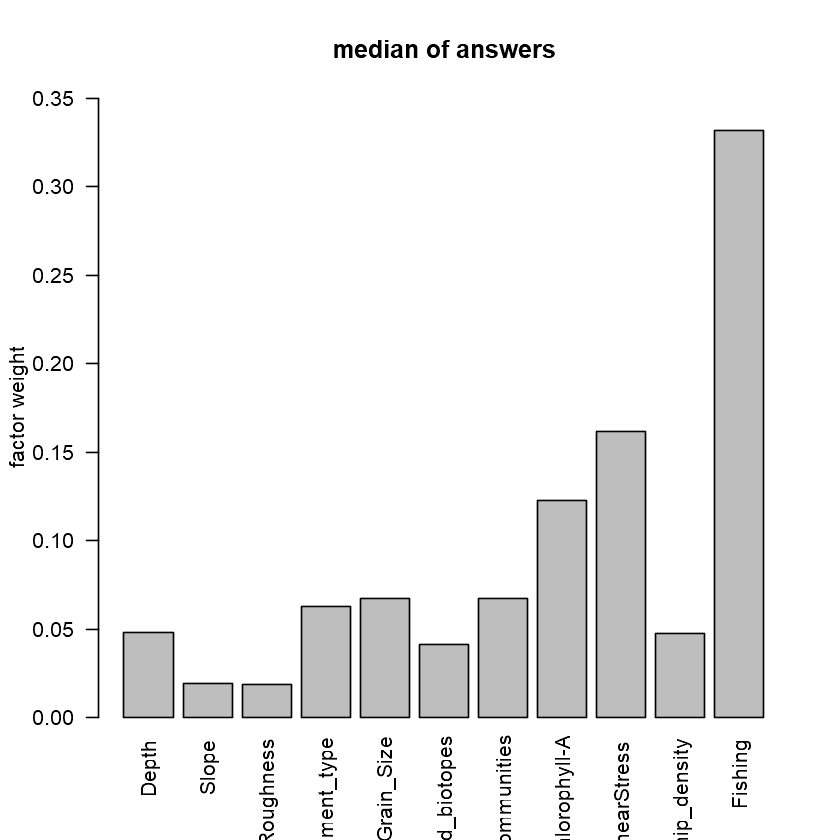

In [23]:
# rearrange into single matrices, one per interviewee
ahp_matrices <- ahp.mat(AHP_Survey, atts, reciprocal = TRUE)

# calculate overall AHP (averaged by arithmetic mean)
ahp_mean <- ahp.aggpref(ahp_matrices, atts, method = "arithmetic")
names(ahp_mean)=atts                                

# calculate median weights
tmpmat=matrix(nrow=max(seq(atts)),ncol=max(seq(files)))                             
for (ians in seq(files)){
  tmp = ahp(AHP_Survey[ians,],atts,method = 'arithmetic')
  for (iatt in seq(length(atts))){
    tmpmat[iatt,ians] = as.numeric(unname(tmp[iatt]))
  }
}
ahp_median <- ahp_mean * 0
for (iatt in seq(length(atts))){
  ahp_median[iatt]<-median(tmpmat[iatt,])
}

# plot factor weightings
barplot(ahp_median, las=2, ylim=c(0,.35),cex.axis=1, font=1,col.axis="black",ylab="factor weight",main='median of answers')

## [IV] Introduce geodata
### (a) Load reference geometries

In [24]:
# Areas of interest: nature protection zones BRG and SAR
AOI_B <- readOGR(dsn = "geodata/NSG Polygons/NSG_BRG_Polygons", layer = "WDPA_Apr2020_protected_area_555638667-shapefile-polygons") 
AOI_S <- readOGR(dsn = "geodata/NSG Polygons/NSG_SAR_Polygons", layer = "WDPA_Apr2020_protected_area_555638666-shapefile-polygons") 
AOI <- AOI_B + AOI_S
projection(AOI) <- "+init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"
AOI <- spTransform(AOI, CRS("+init=epsg:25832")) # Transform to utm32N, 25832 

# create empty reference raster, fixed CRS, 50m resolution
newproj <- "+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs" # set projection description 
emptyraster <- raster(extent(AOI))
projection(emptyraster) <- newproj
res(emptyraster) <- 50.0

OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\marko\UNTERLAGEN\JADE\2021-07 - Austern Paper\R_solution_2021\geodata\NSG Polygons\NSG_BRG_Polygons", layer: "WDPA_Apr2020_protected_area_555638667-shapefile-polygons"
with 1 features
It has 28 fields
OGR data source with driver: ESRI Shapefile 
Source: "C:\Users\marko\UNTERLAGEN\JADE\2021-07 - Austern Paper\R_solution_2021\geodata\NSG Polygons\NSG_SAR_Polygons", layer: "WDPA_Apr2020_protected_area_555638666-shapefile-polygons"
with 1 features
It has 28 fields


### (b) Preprocessed factorial and exclusional geodata of the same resolution is loaded 
(No respective Python/R code is published until yet further notice, please ask authors for information)

In [25]:
# load factor filenames and attributes to dataframe
factors   <- stack(raster('./tifs/F_ChlA_new.tif'),
                   raster('./tifs/F_Depth.tif'),
                   raster('./tifs/F_Fish_trawling.tif'),
                   raster('./tifs/F_KGS.tif'),
                   raster('./tifs/F_LG.tif'),
                   raster('./tifs/F_MGS.tif'),
                   raster('./tifs/F_Roughness.tif'),
                   raster('./tifs/F_Sedi.tif'),
                   raster('./tifs/F_Shear.tif'),
                   raster('./tifs/F_Slope.tif'),
                   raster('./tifs/F_Vessel.tif'))
names(factors) <- c('Chlorophyll','Depth','Fishing.present','Biotopes','Benth.communities','Grain.size','Roughness','Sediments','Shear.stress','Slope','Vessel.density')
factor_df <- data.frame(names(factors),
                        c('more','more','less','less','less','more','more','less','less','less','less'),
                        c('eq_interv','eq_interv','other','eq_interv','eq_interv','eq_interv','eq_interv','eq_interv','eq_interv','eq_interv','eq_interv'),                        c('Chlorophyll-A','Depth','Fishing','Modelled_biotopes','Benthic_communities','Median_Grain_Size','Roughness','Sediment_type','ShearStress','Slope','Ship_density'))
colnames(factor_df) <- c('factor','better','spacing','NameInAHP')

exclusions<- stack(raster('./tifs/Excl_Ammun.tif'),
                   raster('./tifs/Excl_Cab.tif'),
                   raster('./tifs/Excl_Pipeline.tif'),
                   raster('./tifs/Excl_Windpark.tif'),
                   raster('./tifs/Excl_Wrecks.tif'),
                   raster('./tifs/Th_Ox_Rc.tif'),
                   raster('./tifs/Th_Sal.tif'),
                   raster('./tifs/Th_Temp.tif'))
names(exclusions) <- c('Ammunition','Cables','Pipelines','Windpark','Wrecks','Oxygen.threshold','Salinity.threshold','Temp.threshold')

no_of_factors <- length(names(factors))
no_of_exclusions <- length(names(exclusions))

### (c) Mask geodata by AOI and crop individual rasters to AOI extent

Chlorophyll   Depth   Fishing.present   Biotopes   Benth.communities   Grain.size   Roughness   Sediments   Shear.stress   Slope   Vessel.density   

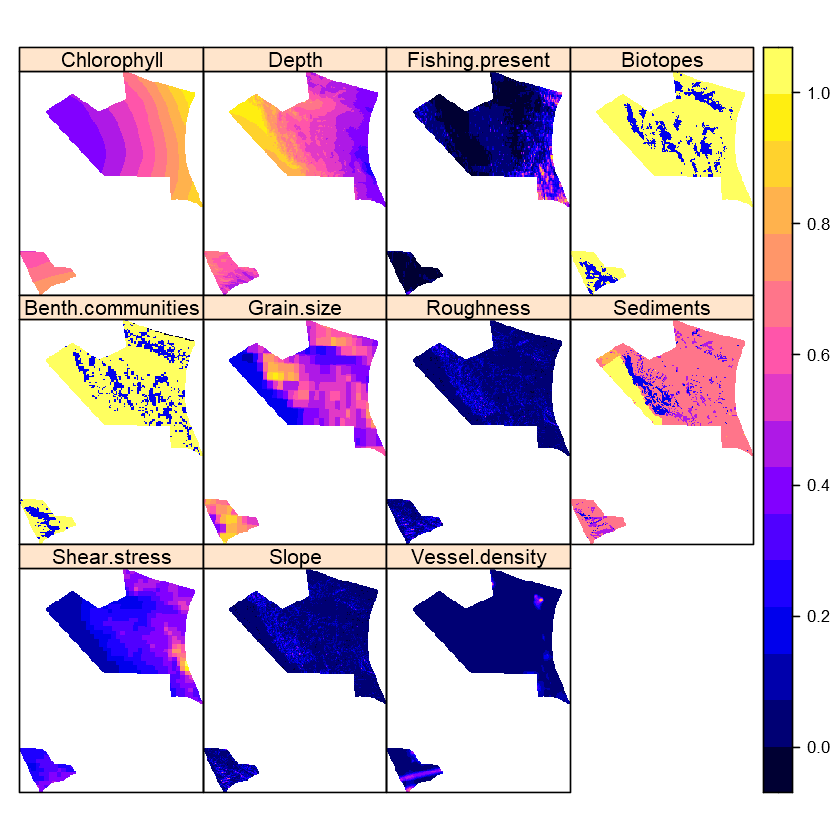

In [27]:
tmpfactors <- factors
for (i in 1:no_of_factors){
  cat(paste(names(factors[[i]]),'  '))
  factors[[i]] <- mask(x = factors[[i]], mask = AOI)
  factors[[i]] <- crop(x = factors[[i]], y = extent(AOI))
  values(tmpfactors[[i]]) <- values(factors[[i]])/nonanabsmax(values(factors[[i]]))
}
spplot(tmpfactors) 

Ammunition   Cables   Pipelines   Windpark   Wrecks   Oxygen.threshold   Salinity.threshold   Temp.threshold   

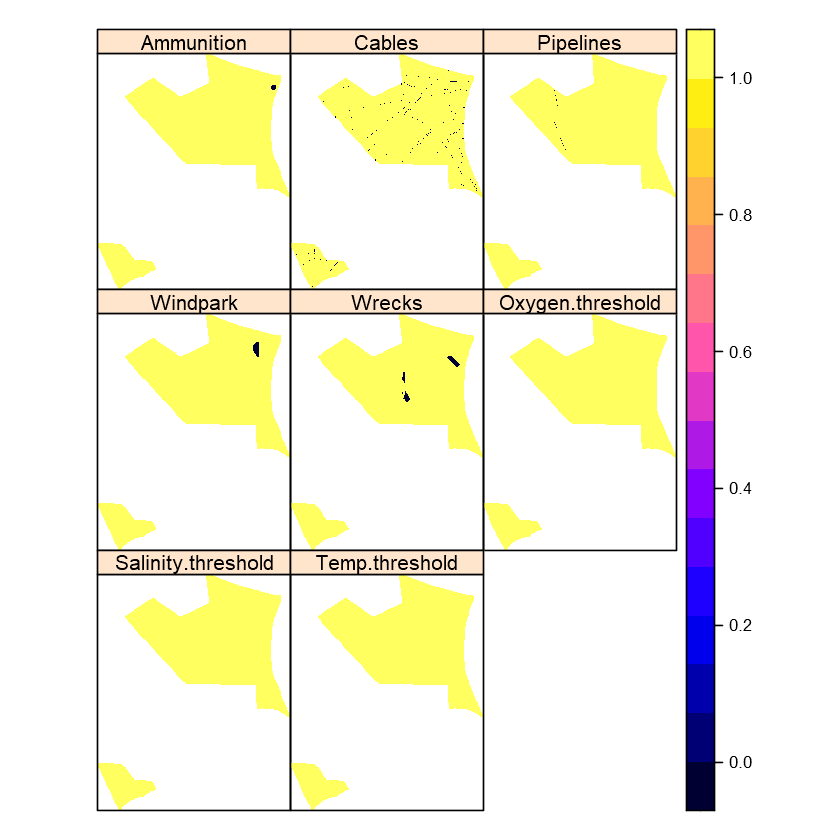

In [28]:
for (i in 1:no_of_exclusions){
  cat(paste(names(exclusions[[i]]),'  '))
  exclusions[[i]] <- mask(x = exclusions[[i]], mask = AOI)
  exclusions[[i]] <- crop(x = exclusions[[i]], y = extent(AOI))
}
spplot(exclusions) 

### (d) Factor reclassification
In accordance to the factor_df dataframe (IVb) the authors decided for equal interval classification for all factors but fishing density, which was tested for different manual classifications due to its strong importance for the overall outcome.

In [31]:
factors_recl <- factors
for (i in 1:no_of_factors){
    direction_test <- factor_df[factor_df$factor==names(factors[[i]]),2] 
    if (direction_test == 'less'){ 
      rating<-seq(1,6) 
    } 
    else { 
      rating<-seq(6,1) 
    }
    
    minv=quantile(values(factors[[i]]),.01,'na.rm'=TRUE) # treat for outlieres 
    factors[[i]][factors[[i]]<=minv] = minv
    maxv=quantile(values(factors[[i]]),.99,'na.rm'=TRUE) # treat for outlieres 
    factors[[i]][factors[[i]]>=maxv] = maxv    
    
    decision <- factor_df[factor_df$factor==names(factors[[i]]),3]
    if (decision == 'eq_interv'){
      tmpcolumn <- seq(minv,maxv,length=7) 
    } else if (decision == 'eq_number'){
      tmpcolumn <- quantile(factors[[i]][!is.na(factors[[i]])],cbind(0,1/6,2/6,3/6,4/6,5/6,1))
      tmpcolumn <- unname(tmpcolumn)
    } else if (decision == 'other'){
      #A) equal quantiles
      #tmpcolumn <- quantile(factors[[i]][!is.na(factors[[i]])],cbind(0,1/6,2/6,3/6,4/6,5/6,1))
      #B) equal intervals
      #tmpcolumn <- seq(minv,maxv,length=7)
      #C) manually 1
      #tmpcolumn <- c(0,0.00001,0.5,1,1.5,2,999)
      #D) manually 2
      tmpcolumn <- c(0,0.00001,1,2,3,4,999)
      tmpcolumn <- unname(tmpcolumn)
    }

    # actual reclassification
    from<-tmpcolumn[1:6]
    to<-tmpcolumn[2:7]
    recl_matrix<-t(rbind(from,to,rating))
    df <- data.frame(recl_matrix)
    factors_recl[[i]] <- reclassify(factors[[i]], recl_matrix, include.lowest=TRUE)
}

## [V] Apply AHP formula with median of expert's weights

In [32]:
# (a) AHP summation (customize factors summands with if)
SUITABILITY <- emptyraster
values(SUITABILITY)<-0
for (i in seq(1,length(names(ahp_median)))){
  weight <- unname(ahp_median[i])
  lookup <- which(factor_df$NameInAHP == names(ahp_median)[i])
  tmprecl <- factors_recl[[lookup]]
  SUITABILITY <- SUITABILITY + weight * tmprecl
  print(names(ahp_median)[i])
}
SUITABILITY_FINAL <- SUITABILITY

[1] "Depth"
[1] "Slope"
[1] "Roughness"
[1] "Sediment_type"
[1] "Median_Grain_Size"
[1] "Modelled_biotopes"
[1] "Benthic_communities"
[1] "Chlorophyll-A"
[1] "ShearStress"
[1] "Ship_density"
[1] "Fishing"


In [33]:
# (b) mask constraint zones by boolean multiplication
EXCLUSIONS <- emptyraster
values(EXCLUSIONS)<-1
for (i in seq(1,length(names(exclusions)))){
  print(names(exclusions[[i]]))
  EXCLUSIONS <- EXCLUSIONS * exclusions[[i]]
}
SUITABILITY_FINAL <- SUITABILITY_FINAL * EXCLUSIONS
SUITABILITY_FINAL[SUITABILITY_FINAL==0] <- NA

[1] "Ammunition"
[1] "Cables"
[1] "Pipelines"
[1] "Windpark"
[1] "Wrecks"
[1] "Oxygen.threshold"
[1] "Salinity.threshold"
[1] "Temp.threshold"


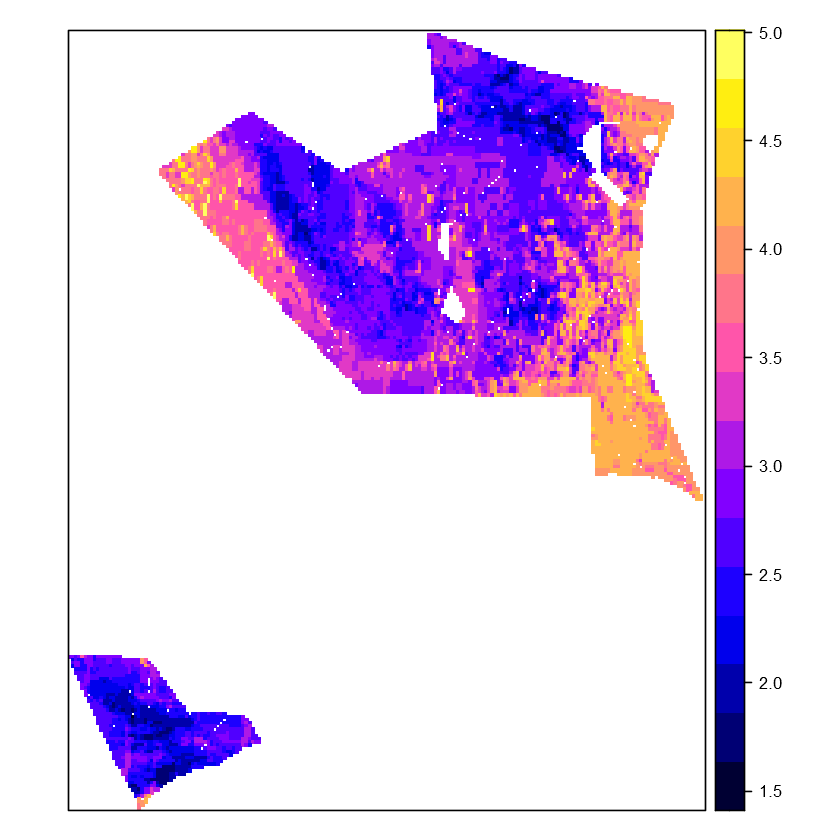

In [34]:
spplot(SUITABILITY_FINAL)

In [35]:
# (c) output to raster file
writeRaster(SUITABILITY_FINAL, filename= "SUITABILITY_FINAL.tif", format="GTiff", overwrite=TRUE)